# ECG Heartbeat Classification

## I. Introduction

![ecg.jpg](ecg.jpg)

Electrocardiography is the process of producing an electrocardiogram (ECG or EKG), a recording – a graph of voltage versus time – of the electrical activity of the heart using electrodes placed on the skin. ECG is a very important and significant tool in heart disease diagnoses.

Changes in the normal ECG pattern occur in numerous cardiac abnormalities, including cardiac rhythm disturbances (such as atrial fibrillation and ventricular tachycardia), inadequate coronary artery blood flow (such as myocardial ischemia and myocardial infarction), and electrolyte disturbances (such as hypokalemia and hyperkalemia).

In this project, I want to classify different arrhytmia types on ECG. 
The [MIT-BIH Arrhythmia Database](https://physionet.org/content/mitdb/1.0.0/) contains 48 half-hour excerpts of two-channel ambulatory ECG recordings, obtained from 47 subjects studied by the BIH Arrhythmia Laboratory between 1975 and 1979. Twenty-three recordings were chosen at random from a set of 4000 24-hour ambulatory ECG recordings collected from a mixed population of inpatients (about 60%) and outpatients (about 40%) at Boston's Beth Israel Hospital; the remaining 25 recordings were selected from the same set to include less common but clinically significant arrhythmias that would not be well-represented in a small random sample.

Arrhythmia Dataset

    Number of Samples: 109446
    Number of Categories: 5
    Sampling Frequency: 125Hz
    Data Source: Physionet's MIT-BIH Arrhythmia Dataset
    Classes: ['N': 0, 'S': 1, 'V': 2, 'F': 3, 'Q': 4]

- N : Non-ecotic beats (normal beat)
- S : Supraventricular ectopic beats
- V : Ventricular ectopic beats
- F : Fusion Beats
- Q : Unknown Beats

*Remark: These signals are preprocessed and segmented, with each segment corresponding to a heartbeat. All the samples are cropped, downsampled and padded with zeroes if necessary to the fixed dimension of 188.*

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from keras.utils.np_utils import to_categorical
from sklearn.utils import class_weight
import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.


In [2]:
train_df=pd.read_csv('mitbih_train.csv',header=None)
test_df=pd.read_csv('mitbih_test.csv',header=None)

In [3]:
train_df[187]=train_df[187].astype(int)
train_df[187].value_counts()

0    72471
4     6431
2     5788
1     2223
3      641
Name: 187, dtype: int64

In [4]:
from sklearn.utils import resample
df_1=train_df[train_df[187]==1]
df_2=train_df[train_df[187]==2]
df_3=train_df[train_df[187]==3]
df_4=train_df[train_df[187]==4]
df_0=(train_df[train_df[187]==0]).sample(n=20000,random_state=42)

df_1_upsample=resample(df_1,replace=True,n_samples=20000,random_state=123)
df_2_upsample=resample(df_2,replace=True,n_samples=20000,random_state=124)
df_3_upsample=resample(df_3,replace=True,n_samples=20000,random_state=125)
df_4_upsample=resample(df_4,replace=True,n_samples=20000,random_state=126)

train_df=pd.concat([df_0,df_1_upsample,df_2_upsample,df_3_upsample,df_4_upsample])

In [5]:
c=train_df.groupby(187,group_keys=False).apply(lambda train_df : train_df.sample(1))
c

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
42954,0.970845,0.755102,0.612245,0.341108,0.218659,0.110787,0.043732,0.029155,0.002915,0.032070,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
73374,0.910526,1.000000,0.342105,0.000000,0.121053,0.210526,0.231579,0.142105,0.105263,0.131579,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
77019,0.025284,0.000000,0.036662,0.111252,0.199747,0.252845,0.326169,0.417193,0.458913,0.512010,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
81055,0.729091,0.980000,1.000000,0.560000,0.240000,0.170909,0.156364,0.140000,0.123636,0.125455,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
86454,1.000000,0.530466,0.508961,0.508961,0.523297,0.519713,0.516129,0.508961,0.462366,0.369176,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4


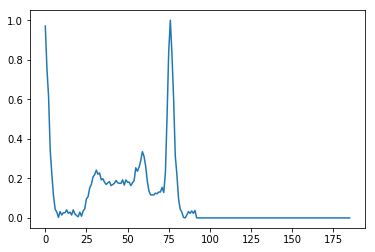

In [6]:
 plt.plot(c.iloc[0,:186])

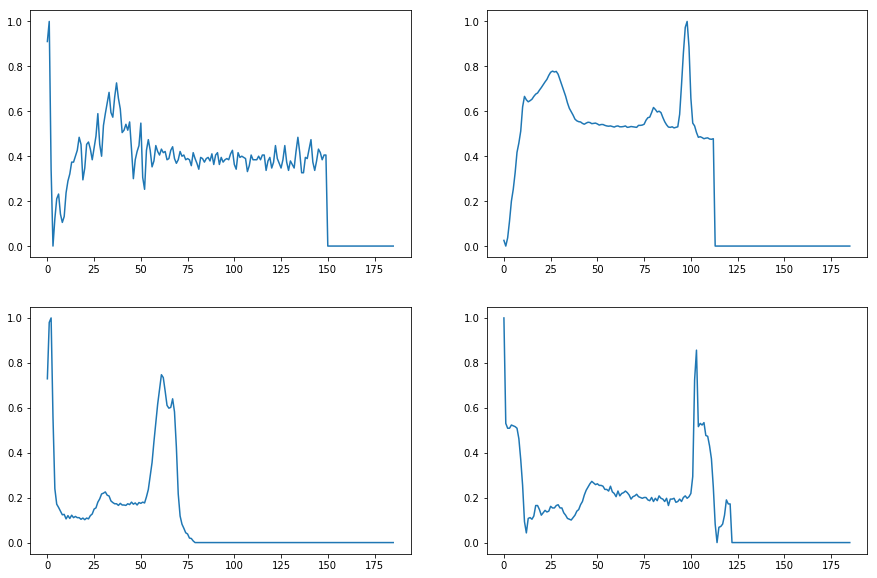

In [7]:
f, axes = plt.subplots(2, 2, sharex=False, sharey=False) 
f.set_figheight(10)
f.set_figwidth(15)
axes[0,0].plot(c.iloc[1,:186])
axes[0,1].plot(c.iloc[2,:186])
axes[1,0].plot(c.iloc[3,:186])
axes[1,1].plot(c.iloc[4,:186])

In [8]:
target_train=train_df[187]
target_test=test_df[187]
y_train=to_categorical(target_train)
y_test=to_categorical(target_test)
X_train=train_df.iloc[:,:186].values
X_test=test_df.iloc[:,:186].values
X_train = X_train.reshape(len(X_train), X_train.shape[1],1)
X_test = X_test.reshape(len(X_test), X_test.shape[1],1)

In [9]:
def network(X_train,y_train,X_test,y_test):
    

    im_shape=(X_train.shape[1],1)
    inputs_cnn=Input(shape=(im_shape), name='inputs_cnn')
    conv1_1=Convolution1D(64, (6), activation='relu', input_shape=im_shape)(inputs_cnn)
    conv1_1=BatchNormalization()(conv1_1)
    pool1=MaxPool1D(pool_size=(3), strides=(2), padding="same")(conv1_1)
    conv2_1=Convolution1D(64, (3), activation='relu', input_shape=im_shape)(pool1)
    conv2_1=BatchNormalization()(conv2_1)
    pool2=MaxPool1D(pool_size=(2), strides=(2), padding="same")(conv2_1)
    conv3_1=Convolution1D(64, (3), activation='relu', input_shape=im_shape)(pool2)
    conv3_1=BatchNormalization()(conv3_1)
    pool3=MaxPool1D(pool_size=(2), strides=(2), padding="same")(conv3_1)
    flatten=Flatten()(pool3)
    dense_end1 = Dense(64, activation='relu')(flatten)
    dense_end2 = Dense(32, activation='relu')(dense_end1)
    main_output = Dense(5, activation='softmax', name='main_output')(dense_end2)
    
    
    model = Model(inputs= inputs_cnn, outputs=main_output)
    model.compile(optimizer='adam', loss='categorical_crossentropy',metrics = ['accuracy'])
    
    
    callbacks = [EarlyStopping(monitor='val_loss', patience=8),
             ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]

    history=model.fit(X_train, y_train,epochs=4,callbacks=callbacks, batch_size=32,validation_data=(X_test,y_test))
    model.load_weights('best_model.h5')
    return(model,history)

In [10]:
from keras.layers import Dense, Convolution1D, MaxPool1D, Flatten, Dropout
from keras.layers import Input
from keras.models import Model
from keras.layers.normalization import BatchNormalization
import keras
from keras.callbacks import EarlyStopping, ModelCheckpoint

model,history=network(X_train,y_train,X_test,y_test)








Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 100000 samples, validate on 21892 samples
Epoch 1/4
100000/100000 [==============================] - 145s 1ms/step - loss: 0.1880 - acc: 0.9339 - val_loss: 0.2178 - val_acc: 0.9171
Epoch 2/4
100000/100000 [==============================] - 144s 1ms/step - loss: 0.0719 - acc: 0.9756 - val_loss: 0.2894 - val_acc: 0.9003
Epoch 3/4
100000/100000 [==============================] - 141s 1ms/step - loss: 0.0471 - acc: 0.9847 - val_loss: 0.1259 - val_acc: 0.9657
Epoch 4/4
100000/100000 [==============================] - 149s 1ms/step - loss: 0.0388 - acc: 0.9874 - val_loss: 0.1432 - val_acc: 0.9577


In [12]:
model.evaluate((X_test),y_test, verbose=0)[1]

0.9657409099214325